# intro
## Take two models, run for 10 epochs. Best result goes for further workflow

In [65]:
!pip install segmentation_models_pytorch
!pip install pycocotools
!pip install optuna
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import random
import numpy as np
import pandas as pd

import optuna


import json
from PIL import Image, ImageDraw

import colorsys
import cv2
import albumentations as A
from tqdm.auto import tqdm

import torch
from pytorch_lightning.loggers import CSVLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weights/modelo.75.ckpt
/kaggle/input/weights/model_0.72.ckpt
/kaggle/input/weights/train_json.json
/kaggle/input/weights/resnet101_reducedfc.pth
/kaggle/input/weights/test_json.json
/kaggle/input/sartorius-cell-instance-segmentation/sample_submission.csv
/kaggle/input/sartorius-cell-instance-segmentation/train.csv
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_train.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_val.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_test.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3/livecell_skov3_test.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3

In [16]:
in_path = "/kaggle/input/"
output_path = "/kaggle/output/"
#https://smp.readthedocs.io/en/latest/quickstart.html

In [17]:
df = pd.read_csv(in_path+'sartorius-cell-instance-segmentation/train.csv')

In [18]:
df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


## YOLOACT data prepare

In [ ]:
# Convert data to COCO like json files

class DatasetConverter:
    def __init__(self, df, img_folder, output_file_name='your_dataset.json'):
        self.df = df
        self.width=704
        self.height=520
        # Assuming cell_types are unique and mapping them to category IDs
        self.cell_types = df['cell_type'].unique()
        self.cls_map = {cell_type: index + 1 for index, cell_type in enumerate(self.cell_types)}
        self.img_folder = img_folder
        self.output_file_name = output_file_name
        self.coco_format = {
            "images": [],
            "annotations": [],
            "categories": []
        }

        # Adding categories to COCO
        for cell_type, id in self.cls_map.items():
            self.coco_format['categories'].append({
                "id": id,
                "name": cell_type
            })

    def get_targets_masks(self, img_id):
        """
        Retrieves targets and masks for a given image ID.
        """
        targets = self.df[self.df['id'] == img_id]['cell_type'].apply(lambda x: self.cls_map[x]).values
        rles = self.df[self.df['id'] == img_id]['annotation'].values
        return targets, rles
    
    #@staticmethod
    def decode_rle_mask(self, rle_mask, shape=(520, 704)):
        """
        Decode run-length encoded segmentation mask string into 2d array
  
        Parameters
        ----------
        rle_mask (str): Run-length encoded segmentation mask string
        shape (tuple): Height and width of the mask

        Returns
        -------
        mask [numpy.ndarray of shape (height, width)]: Decoded 2d segmentation mask
        """

        rle_mask = rle_mask.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
        starts -= 1
        ends = starts + lengths

        mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
        for start, end in zip(starts, ends):
            mask[start:end] = 1

        mask = mask.reshape(shape[0], shape[1])
        mask = np.uint8(mask)
        return mask
    
    def calculate_bbox(self, mask):
        """
        Calculate the bounding box of a mask.

        Parameters:
        mask (numpy.ndarray): A 2D numpy array where the mask is.

        Returns:
        list: Bounding box [x_min, y_min, width, height].
        """
        # Find all non-zero points (i.e., mask points)
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]

        # Calculate bounding box
        width = x_max - x_min + 1
        height = y_max - y_min + 1

        return [int(x_min), int(y_min), int(width), int(height)]
    
    def rle_to_polygon(self, rle_mask, shape=(520, 704)):
        """
        Convert RLE mask string to polygon points.
        """
        # First, decode the RLE mask to a binary mask
        mask = self.decode_rle_mask(rle_mask, shape)
        
        
        # Find contours from the binary mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Assuming the largest contour is the object to find
        # This part might need to be adjusted based on your dataset
        contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        
        # Simplify contour to polygon
        epsilon = 0.005 * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        
        # Flatten the polygon array and convert to list
        polygon = polygon.flatten().tolist()
        
        # Ensure the polygon is closed by making the last vertex the same as the first
        if polygon[:2] != polygon[-2:]:
            polygon.extend(polygon[:2])
        
        # Convert the coordinate pairs to the COCO polygon format, which is [x1,y1,x2,y2,...]
        # Optionally, you might want to scale or transform these coordinates depending on your image dimensions or requirements
        return [float(coord) for coord in polygon]
    
    def convert_to_coco(self):
        annotation_id = 1
        img_id = 1
        
        
        for uid in self.df['id'].unique():
            self.coco_format['images'].append({
                "id": img_id,
                "width": self.width,
                "height": self.height,
                "file_name": f"{uid}.png"
            })
            
            
            targets, rles = self.get_targets_masks(uid)
            for target, rle in zip(targets, rles):
                segmentation_polygon = self.rle_to_polygon(rle, shape=(self.height, self.width))
                mask = self.decode_rle_mask(rle, shape=(self.height, self.width))
                area = np.sum(mask).tolist()  # Calculating the area of the mask
                bbox = self.calculate_bbox(mask)
                bbox = [float(coord) for coord in bbox]
                self.coco_format['annotations'].append({
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": int(target),
                    "segmentation": [segmentation_polygon],
                    "area": area,
                    "bbox": bbox, 
                    "iscrowd": 0
                })
               
                annotation_id += 1
            img_id +=1

        with open(self.output_file_name, 'w') as outfile:
            json.dump(self.coco_format, outfile, indent=4, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)



unique_ids = df['id'].unique()

# Split the unique IDs into training and testing groups
train_ids, test_ids = train_test_split(unique_ids, test_size=0.1, random_state=42)

# Create DataFrames for training and testing based on the split IDs
train_df = df[df['id'].isin(train_ids)]
test_df = df[df['id'].isin(test_ids)]

# Proceed with your DatasetConverter instances
img_folder = in_path+'sartorius-cell-instance-segmentation/train/'

train_converter = DatasetConverter(train_df, img_folder,'train_json.json')
test_converter = DatasetConverter(test_df, img_folder,'test_json.json')

train_converter.convert_to_coco()  
test_converter.convert_to_coco() 
print('done')

In [ ]:
# Data check using visualization

def visualize_random_images_segmentations(json_path, samples=4):
    # Load data from the JSON file
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    # Randomly select four images, ensuring no duplication
    selected_images = random.sample(data['images'], min(samples, len(data['images'])))
    
    for image_data in selected_images:
        image_id = image_data['id']
        
        # Filter annotations for the selected image
        annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
        
        # Load the original image
        img_path = f'/kaggle/input/sartorius-cell-instance-segmentation/train/{image_data["file_name"]}'
        img_original = Image.open(img_path)
        img_with_segmentations = Image.open(img_path)
        img_with_bboxes = Image.open(img_path)
        
        # Draw segmentation polygons on the second image
        draw_seg = ImageDraw.Draw(img_with_segmentations)
        for ann in annotations:
            # Assuming 'segmentation' is a list of polygons, each represented by a list of points
            for segmentation in ann.get('segmentation', []):
                # Draw each polygon, assuming segmentation points are [x1, y1, x2, y2, ..., xn, yn]
                draw_seg.polygon(segmentation, outline='black')
        
        # Draw bounding boxes on the third image
        draw_box = ImageDraw.Draw(img_with_bboxes)
        for ann in annotations:
            bbox = ann['bbox']
            draw_box.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], outline='red', width=2)
        
        # Display images side by side
        plt.figure(figsize=(35, 10))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_original)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_with_segmentations)
        plt.title('With Segmentations')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img_with_bboxes)
        plt.title('With Bounding Boxes')
        plt.axis('off')

        plt.show()

json_path = '/kaggle/input/weights/test_json.json'
visualize_random_images_segmentations(json_path, samples=2)



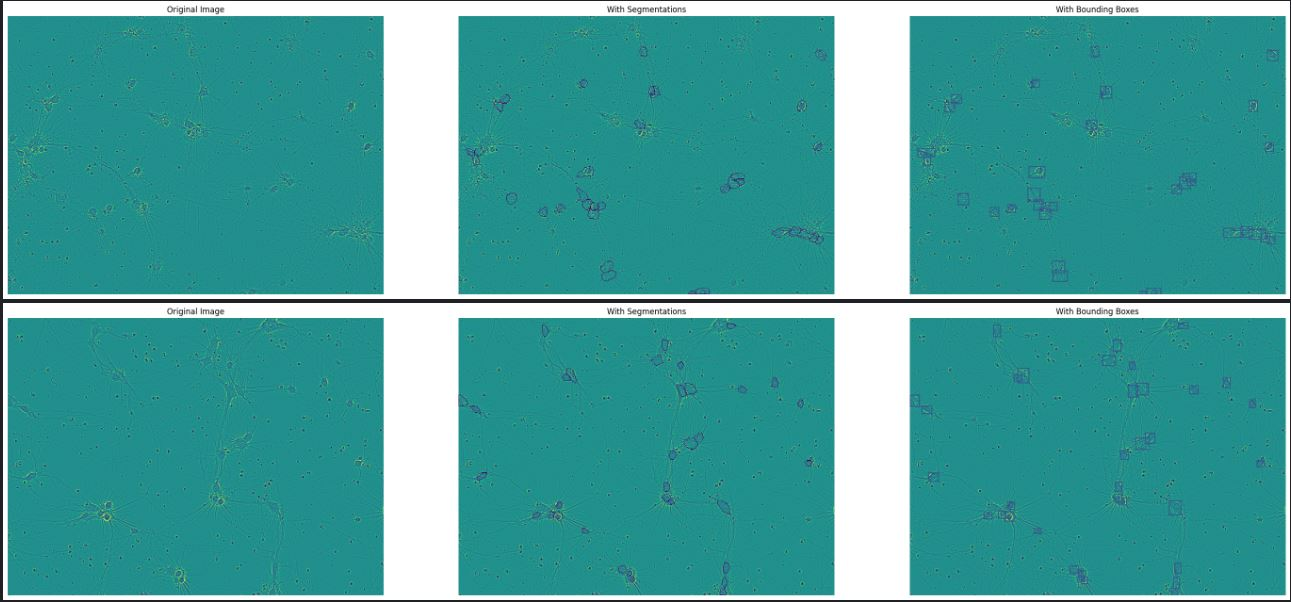

## Yolact model prepare

In [ ]:
!git clone https://github.com/dbolya/yolact.git

In [ ]:
# got some issues with model, had to change some code parts

def bug_killer(start_line, end_line, new_lines, file_path):
    """
    Replaces lines in a file between `start_line` and `end_line` (inclusive) with `new_lines`.
    
    Parameters:
    - start_line: The first line to be replaced (1-indexed).
    - end_line: The last line to be replaced (1-indexed).
    - new_lines: The new content to insert in place of the specified range.
    - file_path: The path to the file where the replacement should occur.
    """
    
    # Read the original file. Open the file at the given `path` in read mode ('r')
    with open(file_path, 'r') as file:  # The variable `file_path` is corrected to `path`
        lines = file.readlines()  # Read all lines of the file into a list

    # Replace the specified lines. Open the file again in write mode ('w') to make changes
    with open(file_path, 'w') as file:
        for i, line in enumerate(lines):  # Iterate through the list of lines with their index `i`
            if start_line <= i + 1 <= end_line:
                # If the current line number is within the range to be replaced,
                # write `new_lines` only once at the start of the range
                if i + 1 == start_line:
                    file.write(new_lines)  # Insert the new content
            else:
                # For lines outside the specified range, write them back to the file unchanged
                file.write(line)


In [ ]:
# Problem & solution
# https://github.com/googlecolab/colabtools/issues/3497

file_path = '/kaggle/working/yolact/utils/augmentations.py'

# Lines to replace the original code with
new_lines = """    def __init__(self):
        self.sample_options = np.array(
            [
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        ],dtype=object,
        )\n"""

start_line = 292
end_line = 303   

bug_killer(start_line, end_line, new_lines, file_path)

In [ ]:
# Problem & solution + some additional changes
# https://github.com/dbolya/yolact/issues/515

file_path = '/kaggle/working/yolact/utils/augmentations.py'

# Lines to replace the original code with
new_lines = """            cv_limit = 512
            if masks.shape[2] <= cv_limit:
                masks = cv2.resize(masks, (width, height))
                if len(masks.shape) == 2:
                    masks = np.expand_dims(masks, axis=-1)
            else:
                resized_masks = [cv2.resize(masks[:, :, i:min(i + cv_limit, masks.shape[2])], (width, height))
                                 for i in range(0, masks.shape[2], cv_limit)]
                resized_masks = [np.expand_dims(mask, axis=-1) if len(mask.shape) == 2 else mask for mask in resized_masks]
                masks = np.concatenate(resized_masks, axis=2)"""


start_line = 158  
end_line = 159    

bug_killer(start_line, end_line, new_lines, file_path)

In [ ]:
# weights actually are resnet50-19c8e357 just wrong naming
!mkdir -p /kaggle/working/weights  
!cp /kaggle/input/weights/resnet101_reducedfc.pth /kaggle/working/weights  
!mv /kaggle/working/weights/resnet101_reducedfc.pth /kaggle/working/weights/resnet50-19c8e357.pth

In [ ]:
# add custom dataset
!sed -i "s/'name': 'Base Dataset'/'name': 'CIS_Dataset'/g" /kaggle/working/yolact/data/config.py
!sed -i "s|'train_images': './data/coco/images/'|'train_images': '/kaggle/input/sartorius-cell-instance-segmentation/train'|g" /kaggle/working/yolact/data/config.py
!sed -i "s|'train_info':   'path_to_annotation_file'|'train_info':   '/kaggle/input/weights/train_json.json'|g" /kaggle/working/yolact/data/config.py
!sed -i "s|'valid_images': './data/coco/images/'|'valid_images': '/kaggle/input/sartorius-cell-instance-segmentation/train'|g" /kaggle/working/yolact/data/config.py
!sed -i "s|'valid_info':   'path_to_annotation_file'|'valid_info':   '/kaggle/input/weights/test_json.json'|g" /kaggle/working/yolact/data/config.py
!sed -i "s/'class_names': COCO_CLASSES/'class_names': ('shsy5y', 'astro', 'cort')/g" /kaggle/working/yolact/data/config.py

# set custom dataset, classes 
!sed -i "s/'dataset': coco2017_dataset/'dataset': dataset_base/g" /kaggle/working/yolact/data/config.py
!sed -i "s/'num_classes': len(coco2017_dataset.class_names) + 1/'num_classes': len(dataset_base.class_names) + 1/g" /kaggle/working/yolact/data/config.py
!sed -i "s/'max_size': 550/'max_size': 520/g" /kaggle/working/yolact/data/config.py

# bug fix
!sed -i 's|generator = torch.Generator()|generator = torch.Generator(device='"'"'cuda'"'"')|g' /opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py
!sed -i 's|torch.randperm(n, generator=generator).tolist()|torch.randperm(n, generator=generator, device='"'"'cuda'"'"').tolist()|g' /opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py

# set epochs number
!sed -i "s/num_epochs = math.ceil(cfg.max_iter \/ epoch_size)/num_epochs = 10/g" /kaggle/working/yolact/train.py

In [ ]:
# train
!python /kaggle/working/yolact/train.py --config=yolact_resnet50_config 

### # Result after 10 epochs
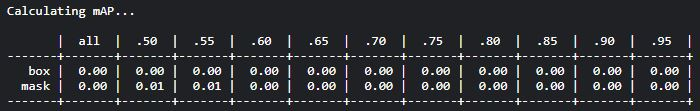

## FPN with resnet34 weights data prepare

In [20]:
class Sartorius(Dataset):
    def __init__(self, df, img_folder, split='train', transform=None, test_size=0.1, random_state=42):
        """
        Dataset class for loading and preprocessing cell images and masks.
        :param df: DataFrame containing the dataset information.
        :param img_folder: Path to the folder containing images.
        :param split: Specifies if the dataset is for training or testing. Expected values are 'train' or 'test'.
        :param transform: Optional transformations to be applied on the images and masks.
        :param test_size: Proportion of the dataset to be used for testing.
        :param random_state: Seed for reproducible splits.
        """
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.split = split
        self.cls_map = {cell_type: idx for idx, cell_type in enumerate(df['cell_type'].unique())}

        # Splitting the dataset into training and testing
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
        if split == 'train':
            self.images_filenames = train_df['id'].unique()
        elif split == 'val':
            self.images_filenames = test_df['id'].unique()
        else:
            raise ValueError(f"Invalid split name: {split}. Expected 'train' or 'val'.")
        
    def decode_rle_mask(self, rle_mask, shape=(520, 704)):
        """
        Decodes a run-length encoded mask.
        """
        rle_mask = rle_mask.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
        starts -= 1
        ends = starts + lengths
        mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
        for start, end in zip(starts, ends):
            mask[start:end] = 1
        mask = mask.reshape(shape)
        return np.uint8(mask)

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.images_filenames)

    def __getitem__(self, idx):
        """
        Returns the image and mask for a given index.
        """
        img_id = self.images_filenames[idx]
        img_path = os.path.join(self.img_folder, f"{img_id}.png")  # Adjust the extension if necessary
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image at {img_path} cannot be read.")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Handling multiple masks per image, if necessary, can combine them here
        _, rles = self.get_targets_masks(img_id)
        #mask = np.zeros((520, 704), dtype=np.uint8)  
        masks = [self.decode_rle_mask(rle, shape=image.shape) for rle in rles]
        # Assuming decoded_masks is a list of 2D numpy arrays (binary masks)
        combined_mask = np.zeros_like(masks[0], dtype=np.float32)

        # Overlay masks - this simple approach adds them up
        for mask in masks:
            combined_mask += mask

        # If you want to cap the values to a maximum (e.g., 1 to keep it binary-like), you can do:
        mask = np.clip(combined_mask, 0, 1)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image,mask

    def get_targets_masks(self, img_id):
        """
        Retrieves targets and masks for a given image ID.
        """
        targets = self.df[self.df['id'] == img_id]['cell_type'].apply(lambda x: self.cls_map[x]).values
        rles = self.df[self.df['id'] == img_id]['annotation'].values
        return targets, rles
    
    def encode_rle_mask(self, mask, shape=(520, 704)):
        """
        Encodes a binary mask to run-length encoding (RLE).
        :param mask: Binary mask to encode.
        :param shape: Shape of the original mask before flattening.
        :return: Run-length encoded mask.
        """
        pixels = mask.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
        rle[1::2] -= rle[::2]
        return rle.tolist()


In [21]:
Sartorius(df,in_path+'sartorius-cell-instance-segmentation/train',split="train").__getitem__(0)

(array([[142, 150, 125, ..., 137, 137, 147],
        [110, 117, 110, ..., 127, 121, 123],
        [126, 127, 118, ..., 134, 127, 118],
        ...,
        [133, 140, 134, ..., 132, 128, 129],
        [128, 137, 142, ..., 139, 133, 126],
        [121, 130, 142, ..., 137, 142, 135]], dtype=uint8),
 array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [22]:
train_dataset = Sartorius(df,in_path+'sartorius-cell-instance-segmentation/train',split="train")
val_dataset = Sartorius(df,in_path+'sartorius-cell-instance-segmentation/train',split="val")

In [ ]:
def display_few_examples_from_data(dataset, n=1):
    figure, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 24))
    for i in range(n):
        image, mask = dataset.__getitem__(i)
        ax[i, 0].imshow(image, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
display_few_examples_from_data(train_dataset, n=2)

In [23]:
aug = A.Compose([
    A.RandomResizedCrop(640, 640, scale=(0.8, 1.0), ratio=(0.9, 1.3)),
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=64, max_width=64, min_holes=1, min_height=32, min_width=32, fill_value=0, p=0.5),
    A.Normalize(mean=[0.485], std=[0.229]),
    ToTensorV2()
])

In [49]:
class CellTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Assuming you're working with RGB images now
        if self.transform:
            image = self.transform(image=image)['image']  # Use the correct key for albumentations
        return image, os.path.basename(image_path)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, os.path.basename(image_path)  # Also return filename for future use
    
test_image_paths = ['/kaggle/input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png',
                    '/kaggle/input/sartorius-cell-instance-segmentation/test/d48ec7815252.png',
                    '/kaggle/input/sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png']
test_dataset = CellTestDataset(test_image_paths, transform=aug)

In [25]:
train_dataset = Sartorius(df,in_path+'sartorius-cell-instance-segmentation/train',split="train",transform=aug)
val_dataset = Sartorius(df,in_path+'sartorius-cell-instance-segmentation/train',split="val",transform=aug)

In [26]:
def IoU(preds, targs, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1, device=targs.device)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [27]:
class CombinedLoss(nn.Module):
    def __init__(self, weights=None):
        super(CombinedLoss, self).__init__()
        if weights is None:
            weights = [1.0, 1.0, 1.0, 1.0, 1.0]  # Default weights: equally balanced
        self.jaccard_loss = smp.losses.JaccardLoss(mode='binary')
        self.dice_loss = smp.losses.DiceLoss(mode='binary')
        self.tversky_loss = smp.losses.TverskyLoss(mode='binary', log_loss=False)
        self.focal_loss = smp.losses.FocalLoss(mode='binary')
        self.lovasz_loss = smp.losses.LovaszLoss(mode='binary')
        self.weights = weights

    def forward(self, inputs, targets):
        jaccard = self.jaccard_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        tversky = self.tversky_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)
        lovasz = self.lovasz_loss(inputs, targets)
        total_loss = (self.weights[0] * jaccard + self.weights[1] * dice + 
                      self.weights[2] * tversky + self.weights[3] * focal + 
                      self.weights[4] * lovasz)
        return total_loss


In [37]:


class SegModel(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset, test_dataset=None, encoder_name='tu-resnext26ts',
                 learning_rate=8e-6, weight_decay=1e-4, freeze_encoder_until_epoch=5):
        super(SegModel, self).__init__()
        self.batch_size = 4
        self.learning_rate = learning_rate
        self.encoder_name = encoder_name
        self.freeze_encoder_until_epoch = freeze_encoder_until_epoch
        self.net = smp.MAnet(encoder_name=encoder_name,#PSPNet
                           encoder_weights="imagenet",
                           in_channels=1,
                           classes=1)

        # Initially freeze the encoder
        for param in self.net.encoder.parameters():
            param.requires_grad = False
        
        self.trainset = train_dataset
        self.valset = val_dataset
        self.testset = test_dataset if test_dataset is not None else val_dataset
        self.weight_decay = weight_decay
        self.criterion = CombinedLoss(weights=[1.0, 0.5, 0.5, 0.2, 0.2])

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        img, mask = batch
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask)
        iou_score = IoU(out.float(), mask.long())
        self.log("train_loss", loss_val)
        self.log("train_iou", iou_score, prog_bar=True)
        return loss_val

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=None, epochs=self.trainer.max_epochs, steps_per_epoch=len(self.train_dataloader()))
        return [optimizer], [scheduler]


    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, prefetch_factor=2, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size, shuffle=False, num_workers=1, prefetch_factor=2, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=1, prefetch_factor=2, persistent_workers=True)

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        img, mask = img.to(self.device), mask.to(self.device)
        out = self.forward(img)
        loss_val = self.criterion(out.squeeze(1), mask)
        iou_score = IoU(out.float(), mask.long())
        self.log("val_loss", loss_val, prog_bar=True, sync_dist=True)
        self.log("val_iou", iou_score, prog_bar=True, on_epoch=True, sync_dist=True)

    def on_epoch_end(self):
        # Unfreeze the encoder gradually or all at once based on the current epoch
        if self.current_epoch >= self.freeze_encoder_until_epoch:
            for param in self.net.encoder.parameters():
                param.requires_grad = True


## FPN hyper parameter search

In [ ]:
'''def objective(trial: optuna.Trial, train_dataset, val_dataset, out_path):
    # Define the hyperparameters to be tuned
    encoder_name = trial.suggest_categorical('encoder_name', ['resnet34', 'mobilenet_v2', 'timm-efficientnet-b3'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'SGD'])
    
    logger = CSVLogger(save_dir=out_path, name="optuna_hpo_logs")
    
    # Create the model with the suggested hyperparameters
    model = SegModel(train_dataset, val_dataset,
                     encoder_name=encoder_name, learning_rate=learning_rate,
                     optimizer_name=optimizer_name, weight_decay=weight_decay)

    # Define the PyTorch Lightning trainer
    trainer = pl.Trainer(
        logger=logger,
        accelerator="auto",
        devices="2",
        strategy="ddp_notebook",
        max_epochs=5
    )

    # Fit the model
    trainer.fit(model)

    # Objective metric to optimize
    val_iou = trainer.callback_metrics["val_iou"].item()
    
    return val_iou'''

In [ ]:
'''def run_optimization(train_dataset, val_dataset, out_path, n_trials=100):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="maximize")
    study.optimize(lambda trial: objective(trial, train_dataset, val_dataset, out_path), n_trials=n_trials)

    print("Best trial:")
    trial = study.best_trial

    print(f"Value: {trial.value}")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")

# Assuming train_dataset, val_dataset, and out_path are predefined
run_optimization(train_dataset, val_dataset, output_path, n_trials=90)'''

#### Best trial:
#### Value: 0.6400721073150635
  * encoder_name: timm-efficientnet-b3
  * learning_rate: 0.0008554651674380874
  * weight_decay: 3.002610219457659e-10
  * optimizer_name: Adam

In [38]:
FPN = SegModel(train_dataset, val_dataset,test_dataset, encoder_name='tu-resnext26ts',
                 learning_rate=8e-6, weight_decay=1e-4)

In [47]:
# Assuming SegModel and all necessary imports and dependencies are already defined
model = SegModel.load_from_checkpoint(checkpoint_path="/kaggle/input/weights/modelo.75.ckpt",
                                      train_dataset=train_dataset,  # you need to provide the datasets again
                                      val_dataset=val_dataset,
                                      test_dataset=test_dataset)

In [39]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    strategy="auto",
    max_epochs=20,#75#
    callbacks=[
        ModelCheckpoint(save_weights_only=True,
                        dirpath="./best_model.pth",
                        mode="max",
                        monitor="val_iou"
                        ),
        LearningRateMonitor("epoch"),
        EarlyStopping(monitor="val_iou", mode="max", patience=15),
    ],  
)

In [48]:
trainer.fit(FPN)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [40]:
trainer.validate(FPN,
                 ckpt_path='/kaggle/input/weights/modelo.75.ckpt',
                 dataloaders=FPN.val_dataloader())

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7507520318031311     │
│         val_loss          │    0.9972671866416931     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9972671866416931, 'val_iou': 0.7507520318031311}]

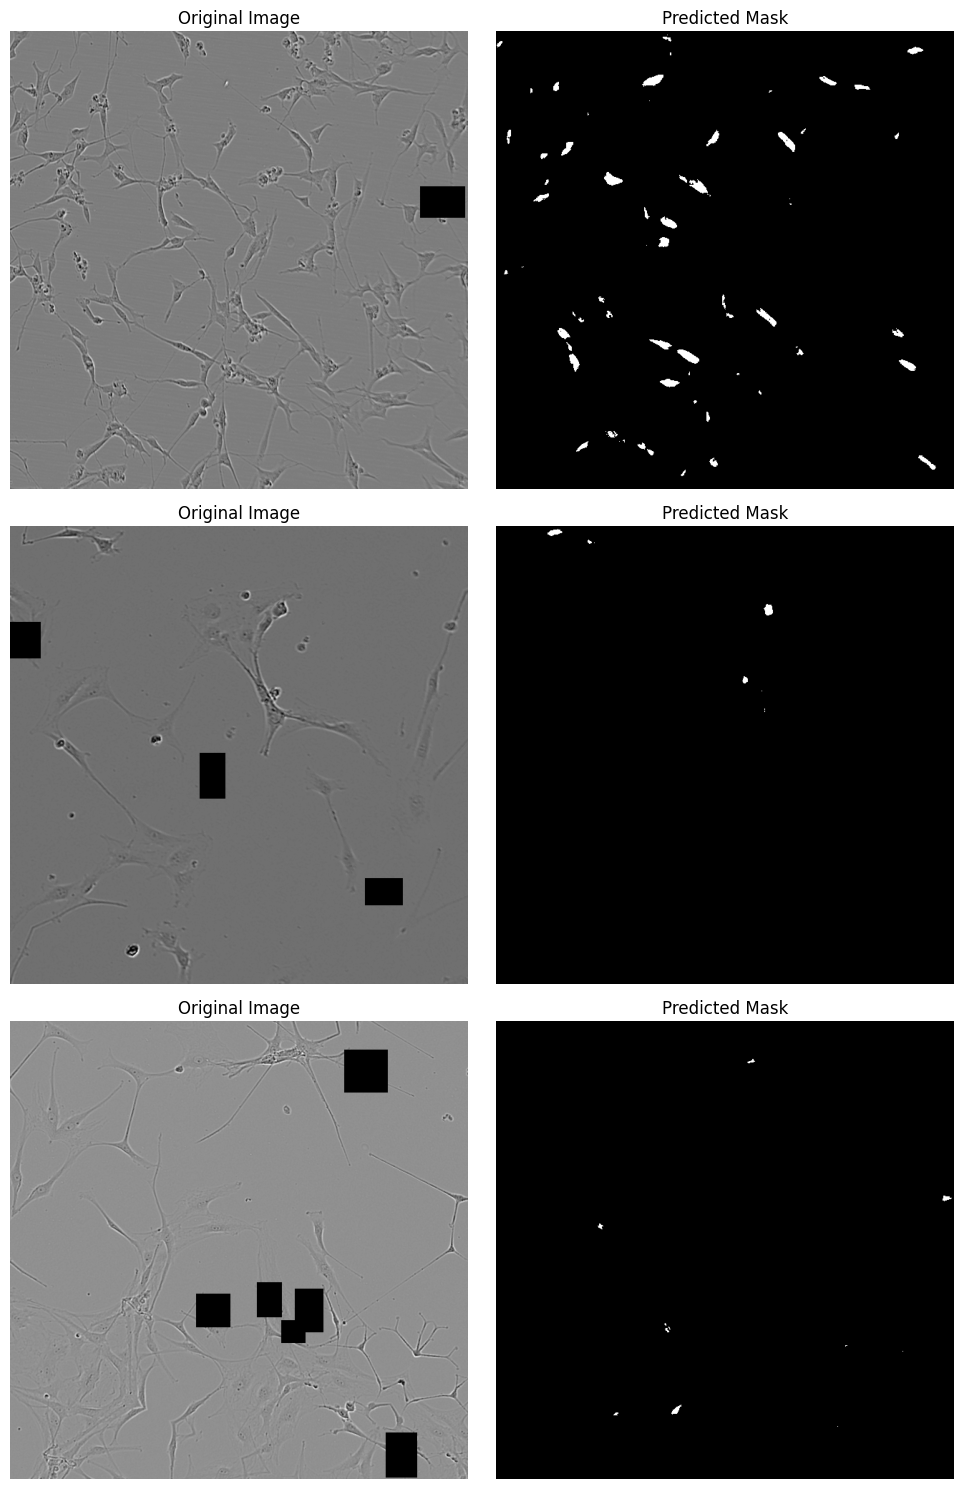

In [51]:
def visualize_segmentation(model, device, dataloader, num_samples=3):
    model = model.to(device)
    model.eval()

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    sample_count = 0  # Initialize sample count

    for images, _ in dataloader:
        images = images.mean(dim=1, keepdim=True)
        images = images.to(device)
        preds = torch.sigmoid(model(images))
        preds = (preds > 0.5).float()
        images, preds = images.cpu(), preds.cpu()

        for idx in range(images.shape[0]):
            if sample_count >= num_samples:  # Check if we have displayed enough samples
                break

            # Visualize the original grayscale image
            axs[sample_count, 0].imshow(images[idx].squeeze(), cmap='gray')
            axs[sample_count, 0].set_title('Original Image')

            # Visualize the predicted mask
            axs[sample_count, 1].imshow(preds[idx].squeeze(), cmap='gray')
            axs[sample_count, 1].set_title('Predicted Mask')

            sample_count += 1  # Increment sample count

        if sample_count >= num_samples:
            break

    for ax in axs.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FPN  # Assuming 'FPN' is a pre-defined model instance
model.to(device)

dataloader = FPN.test_dataloader()  # Adjust the batch size if possible in the dataloader definition

visualize_segmentation(model, device, dataloader, num_samples=3)


In [52]:
def rle_encoding(x):
    """
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as string formatted
    """
    dots = np.where(x.T.flatten() == 1)[0]  # Transpose and flatten to row-major order
    run_lengths = []  # list of run lengths
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))  # We start positions at 1
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(i) for i in run_lengths])


In [66]:

# Function to process and predict the dataset
def process_dataset(model, device, dataloader):
    model.eval()
    submission_dict = {'id': [], 'predicted': []}
    with torch.no_grad():
        for images, image_ids in dataloader:
            images = images.mean(dim=1, keepdim=True)
            images = images.to(device)
            preds = torch.sigmoid(model(images))  # Assuming binary classification
            preds = (preds > 0.5).float()  # Threshold predictions

            preds = preds.cpu().numpy()  # Convert to numpy array for RLE encoding

            for pred, image_id in zip(preds, image_ids):
                rle = rle_encoding(pred.squeeze())  # Squeeze to remove channel dimension
                submission_dict['id'].append(image_id.replace('.png', ''))
                submission_dict['predicted'].append(rle)

    return submission_dict

# Assuming your DataLoader and model are correctly defined and loaded
submission_dict = process_dataset(model, device, dataloader)

# Convert dictionary to DataFrame
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv('submission.csv', index=False)


In [67]:
submission_df.head()

,id,predicted
0,7ae19de7bc2a,
1,d48ec7815252,12730 1 13374 1 14013 3 16739 4 17378 8 18016 ...
2,d8bfd1dafdc4,11740 1 12379 2 13018 3 13658 4 14298 2 24914 ...


### Conclusion
* I took MAnet model, because YOLOACT did not show any result
* To improve MAnet results add CombinedLoss got 10% better results
* Model got 0.75 score
* While was doing submission noticed that 'Each row in your submission represents a single predicted nucleus segmentation for the given ImageId'
  * I was teaching model on whole images. I lost motivation to change everything, but it is totaly my falt, had to make better research before start